In [18]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from dotenv import load_dotenv
load_dotenv()
llm = ChatOpenAI(model='gpt-4o-mini')
llm.invoke("what is capital of France").content

'The capital of France is Paris.'

In [19]:
from typing_extensions import TypedDict
class State(TypedDict):
  application: str
  experience_level: str
  skill_match : str
  response: str

In [20]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

In [21]:
from langchain_core.prompts import ChatPromptTemplate

In [22]:
def categorize_experience(state: State) -> State:
  print("\nCategorizing the experience level of candidate : ")
  prompt = ChatPromptTemplate.from_template(
      "Based on the following job application, categorize the candidate as 'Entry-level', 'Mid-level' or 'Senior-level'"
      "Application : {application}"
  )
  chain = prompt | llm
  experience_level = chain.invoke({"application": state["application"]}).content
  print(f"Experience Level : {experience_level}")
  return {"experience_level" : experience_level}

def assess_skillset(state: State) -> State:
  print("\nAssessing the skillset of candidate : ")
  prompt = ChatPromptTemplate.from_template(
      "Based on the job application for a Python Developer, assess the candidate's skillset"
      "Respond with either 'Match' or 'No Match'"
      "Application : {application}"
  )
  chain = prompt | llm
  skill_match = chain.invoke({"application": state["application"]}).content
  print(f"Skill Match : {skill_match}")
  return {"skill_match" : skill_match}

def schedule_hr_interview(state: State) -> State:
  print("\nScheduling the interview : ")
  return {"response" : "Candidate has been shortlisted for an HR interview."}

def escalate_to_recruiter(state: State) -> State:
  print("Escalating to recruiter")
  return {"response" : "Candidate has senior-level experience but doesn't match job skills."}

def reject_application(state: State) -> State:
  print("Sending rejecting email")
  return {"response" : "Candidate doesn't meet JD and has been rejected."}

In [23]:
workflow.add_node("categorize_experience", categorize_experience)
workflow.add_node("assess_skillset", assess_skillset)
workflow.add_node("schedule_hr_interview", schedule_hr_interview)
workflow.add_node("escalate_to_recruiter", escalate_to_recruiter)
workflow.add_node("reject_application", reject_application)

In [24]:
def route_app(state: State) -> str:
  print(f"\nRouting decision: skill_match='{state['skill_match']}', experience_level='{state['experience_level']}'")
  
  # Path A: Skill Match = "Match" → Schedule HR Interview
  if "Match" in state["skill_match"]:
    print("→ Path A: Skill matched! Scheduling HR interview")
    return "schedule_hr_interview"
  
  # Path B: Senior-level experience → Escalate to Recruiter
  elif "Senior" in state["experience_level"]:
    print("→ Path B: Senior-level experience. Escalating to recruiter")
    return "escalate_to_recruiter"
  
  # Path C: Default → Reject Application
  else:
    print("→ Path C: Doesn't match criteria. Rejecting application")
    return "reject_application"

In [25]:
workflow.add_edge("categorize_experience", "assess_skillset")
workflow.add_conditional_edges("assess_skillset", route_app)

In [26]:
workflow.add_edge(START, "categorize_experience")
workflow.add_edge("schedule_hr_interview", END)
workflow.add_edge("escalate_to_recruiter", END)
workflow.add_edge("reject_application", END)

In [27]:
app = workflow.compile()

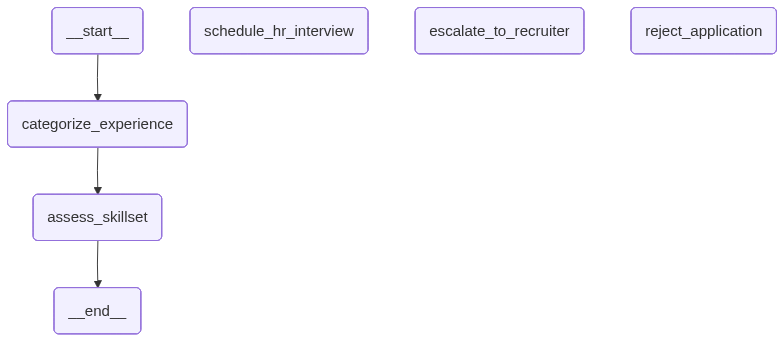

In [28]:
app

✓ Updated graph saved to: d:\WORK\gen-ai-2026\recruitment_graphs\recruitment_workflow.png


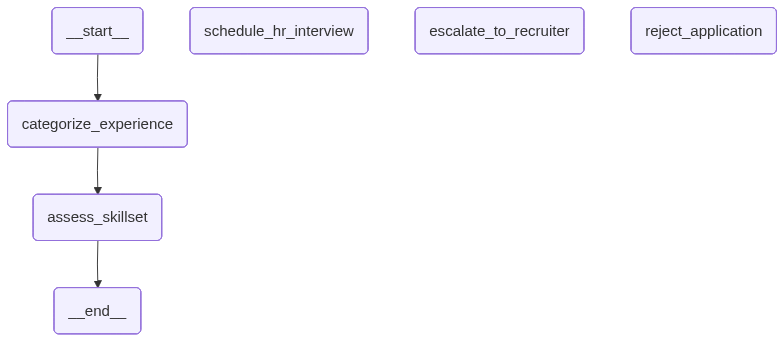

In [34]:
# Regenerate and save the updated graph visualization
import os

# Create output directory if it doesn't exist
output_dir = "../recruitment_graphs"
os.makedirs(output_dir, exist_ok=True)

# Generate and save the graph
graph_image = app.get_graph().draw_mermaid_png()
graph_path = os.path.join(output_dir, "recruitment_workflow.png")

with open(graph_path, 'wb') as f:
    f.write(graph_image)

print(f"✓ Updated graph saved to: {os.path.abspath(graph_path)}")

# Display in notebook
from IPython.display import Image, display
display(Image(graph_path))

In [30]:
def run_candidate_screening(application: str):
  results = app.invoke({"application" : application})
  return {
      "experience_level" : results["experience_level"],
      "skill_match" : results["skill_match"],
      "response" : results["response"]
  }

In [31]:
application_text = "I have 10 years of experience in software engineering with expertise in JAVA"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on the information provided in the application, the candidate would be categorized as 'Senior-level'. The 10 years of experience in software engineering indicates a significant level of expertise and likely a range of responsibilities that align with a senior position.

Assessing the skillset of candidate : 
Experience Level : Based on the information provided in the application, the candidate would be categorized as 'Senior-level'. The 10 years of experience in software engineering indicates a significant level of expertise and likely a range of responsibilities that align with a senior position.

Assessing the skillset of candidate : 
Skill Match : No Match

Routing decision: skill_match='No Match', experience_level='Based on the information provided in the application, the candidate would be categorized as 'Senior-level'. The 10 years of experience in software engineering indicates a significant level of exp

In [32]:
application_text = "I have 1 year of experience in software engineering with expertise in JAVA"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on the provided application, the candidate can be categorized as 'Entry-level' due to having only 1 year of experience in software engineering.

Assessing the skillset of candidate : 
Experience Level : Based on the provided application, the candidate can be categorized as 'Entry-level' due to having only 1 year of experience in software engineering.

Assessing the skillset of candidate : 
Skill Match : No Match

Routing decision: skill_match='No Match', experience_level='Based on the provided application, the candidate can be categorized as 'Entry-level' due to having only 1 year of experience in software engineering.'
→ Path A: Skill matched! Scheduling HR interview

Scheduling the interview : 


Computed Results :
Application: I have 1 year of experience in software engineering with expertise in JAVA
Experience Level: Based on the provided application, the candidate can be categorized as 'Entry-level' due to

In [33]:
application_text = "I have experience in software engineering with expertise in Python"
results = run_candidate_screening(application_text)
print("\n\nComputed Results :")
print(f"Application: {application_text}")
print(f"Experience Level: {results['experience_level']}")
print(f"Skill Match: {results['skill_match']}")
print(f"Response: {results['response']}")


Categorizing the experience level of candidate : 
Experience Level : Based on the job application statement, "I have experience in software engineering with expertise in Python," it's not possible to accurately determine the candidate's level (Entry-level, Mid-level, or Senior-level) without further context regarding their years of experience, specific projects, or responsibilities. 

However, if I had to make an assumption based solely on the provided information, it leans towards "Entry-level" as it suggests basic experience without indicating advanced responsibilities or extensive experience that would be expected at the Mid-level or Senior-level. But this categorization can vary widely based on additional details typically included in a job application, such as years of experience or involvement in projects.

Assessing the skillset of candidate : 
Skill Match : Match

Routing decision: skill_match='Match', experience_level='Based on the job application statement, "I have experienc